# Import libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
np.random.seed(21)

# Load Dataset

The data set used to train the model is [Titanic Dataset](https://www.kaggle.com/competitions/titanic/data) that has been processed in file `data_preprocessing.ipynb`.

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Basic ML/datasets/cleaned-data/data_v2/train.csv', index_col='PassengerId')
val_df = pd.read_csv('/content/drive/MyDrive/Basic ML/datasets/cleaned-data/data_v2/val.csv', index_col='PassengerId')
test_df = pd.read_csv('/content/drive/MyDrive/Basic ML/datasets/cleaned-data/data_v2/test.csv', index_col='PassengerId')

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((712, 8), (179, 8), (418, 7))

In [ ]:
scale_features = ['Age', 'Fare', 'FamilySize']
encoder_features = ['Sex', 'Embarked', 'Title_Name']

features = train_df.columns.to_list()
features.remove('Survived')

# Use GridSearchCV to find suitable Hyperparameters

In [ ]:
# Extract features and Label
X_train = train_df[features]
y_train = train_df['Survived']

X_val = val_df[features]
y_val = val_df['Survived']

In [ ]:
gr_numerical_transformer = StandardScaler()
gr_categorical_transformer = OneHotEncoder()

gr_preprocessor = ColumnTransformer(
    transformers=[
        ('num', gr_numerical_transformer, scale_features),
        ('cat', gr_categorical_transformer, encoder_features)
    ])

gr_pipeline = Pipeline(steps=[
    ('preprocessor', gr_preprocessor),
    ('classifier', SVC())
])

# Define the hyperparameter grid for GridSearchCV

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100, 1000],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__degree': [2, 3, 4, 5], # for poly kernel
}

In [ ]:
# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=gr_pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'FamilySize']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'Embarked',
                                                                          'Title_Name'])])),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100, 1000],
                         'classifier__class_weight': [None, 'balanced'],
                         'classifier__degree': [2, 3, 4, 5],
                         'classifier__kernel': ['linear', 'poly', 'rbf',
                                                'sigmoid']},
             scoring='accuracy', verbose=2)

In [ ]:
# Best hyperparameters and corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__degree': 2, 'classifier__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.8216586230670739


# Training a SVM Model

Use [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) library to build Support Vector Classification model the hyperparameters found in GridSearchCV.

In [ ]:
# Extract features and Label
X_train = train_df[features]
y_train = train_df['Survived']

X_val = val_df[features]
y_val = val_df['Survived']

X_test = test_df[features]

In [ ]:
# Create a Preprocessing Pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, scale_features),
        ('cat', categorical_transformer, encoder_features)
    ])

In [ ]:
# Define and Train the Logistic Regression Model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(C=1, class_weight=None, kernel='rbf', probability = True))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Fare',
                                                   'FamilySize']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'Embarked',
                                                   'Title_Name'])])),
                ('classifier', SVC(C=1, probability=True))])

In [ ]:
y_pred = model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")

Accuracy: 0.8435754189944135


In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       110
           1       0.83      0.75      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



# Evaluating Classification Model

## Confusion Matrix

In [ ]:
def show_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, normalize: bool=False) -> None:
  """

  """
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(5,5))
  confusion = confusion_matrix(y_true, y_pred)

  axis_labels = range(2)

  if normalize:
    confusion = confusion / confusion.sum(axis=1, keepdims=True)
    ax = sns.heatmap(
        confusion, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.4f', square=True, vmin=0, vmax=1)
  else:
    ax = sns.heatmap(
        confusion, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='d', square=True, vmin=0, vmax=len(y_pred))

  plt.title(f"Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

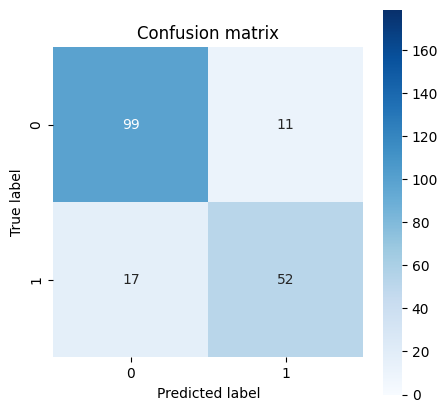

In [ ]:
show_confusion_matrix(y_val, y_pred)

In [ ]:
y_val.value_counts()

,count
Survived,
0,110
1,69


**Remarks:** The model performs well in predicting class 0 (high TN).
- **True Negatives (TN):** 99 instances of class 0 were correctly predicted as 0.
- **False Positives (FP):** 11 instances of class 0 were incorrectly predicted as 1.
- **False Negatives (FN):** 17 instances of class 1 were incorrectly predicted as 0.
- **True Positives (TP):** 52 instances of class 1 were correctly predicted as 1.

## Classification Report

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       110
           1       0.83      0.75      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



**Remarks:**
- **Class 0:** High performance (Precision: 0.85, Recall: 0.90, F1: 0.88).
- **Class 1:** Decent performance but lower recall (Precision: 0.83, Recall: 0.75, F1: 0.79).
- **Accuracy:** The overall accuracy (84%) indicates a fairly strong model.
- The model performs better for the majority class (class 0) due to higher recall and F1-score.

## ROC Curve and AUC Scores

AUC: 0.838


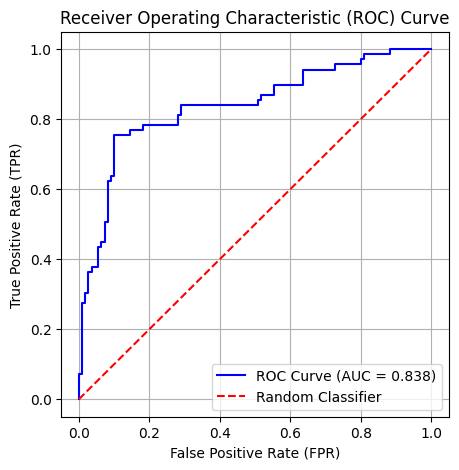

In [ ]:
# Predict probabilities for the positive class
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# Calculate AUC
auc = roc_auc_score(y_val, y_pred_proba)
print(f"AUC: {auc:.3f}")

# Plot ROC Curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Remarks:**
- An AUC of 0.838 indicates a strong model performance, as it demonstrates good discriminative ability between positive and negative classes.
- The ROC curve (blue line) is well above the diagonal random classifier (red line), confirming that the model significantly outperforms random guessing.
- The curve is steep in the initial segment, suggesting the model achieves a high True Positive Rate (TPR) for low False Positive Rates (FPR).

In [ ]:
result_metrics_df = pd.read_csv("/content/drive/MyDrive/Basic ML/source codes/result_metrics.csv")

# Save results for comparison between models
from sklearn.metrics import precision_score, recall_score, f1_score

new_row = pd.DataFrame({
    'Model': 'SVM',
    'Accuracy': accuracy_score(y_val, y_pred),
    'Precision': precision_score(y_val, y_pred),
    'Recall': recall_score(y_val, y_pred),
    'F1-Score': f1_score(y_val, y_pred)
}, index=[len(result_metrics_df)])

result_metrics_df = pd.concat([result_metrics_df, new_row], ignore_index=True)

result_metrics_df

,Model,Accuracy,Precision,Recall,F1-Score
0,CART,0.821229,0.862745,0.637681,0.733333
1,Random Forest,0.815642,0.800000,0.695652,0.744186
2,Naive Bayes,0.793296,0.750000,0.695652,0.721805
3,SVM,0.843575,0.825397,0.753623,0.787879


In [ ]:
result_metrics_df.to_csv('/content/drive/MyDrive/Basic ML/source codes/result_metrics.csv', index=False)